In [1]:
from queue import Queue
from threading import Thread
from itertools import permutations

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from environment import Env

In [2]:
data = pd.read_csv("SH_SDS_data_4.csv", index_col=0)
data.current_state = [('000'+str(cs))[-3:] for cs in data.current_state]
prob = pd.read_csv("SH_SDS_transition_matrix.csv", index_col=0)
prob.index = [('000'+str(idx))[-3:] for idx in prob.index]

In [3]:
def sniper(state_1, state_2, env, start_state):
    state = start_state
    done = False
    all_rewards = list()
    while not done:
        if state[0] == state_1:
            state, reward, done, _ = env.step(0)
        elif state[0] == state_2:
            state, reward, done, _ = env.step(1)
        else:
            state, reward, done, _ = env.step(2)
        all_rewards.append(reward)
    return all_rewards

In [17]:
def thread_sniper(pairs, queue):
    env = Env(data, prob, 0, [1000, -500], 1000)
    start = env.reset()
    strategy_rewards = dict()
    bad_pairs = list()
        
    for p1, p2 in pairs:
        temp_list = list()
        for _ in range(10):
            start = env.reset()
            try:
                temp_list.append(sniper(mappings[p1], mappings[p2], env, start)[-1]) 
            except KeyError:
                bad_pairs.append((p1, p2))
        strategy_rewards[(p1, p2)] = temp_list
        
    queue.put(strategy_rewards)

In [ ]:
env = Env(data, prob, 0, [1000, -500], 1000)
mappings = env.mapping
pairs = list(permutations(mappings.keys(), 2))
q = Queue()

nthreads = 8
arg_len = len(pairs) // nthreads

threads = list()

for i in range(nthreads):
    t = Thread(target=thread_sniper, args=(pairs[i*arg_len:(i+1)*arg_len], q))
    threads.append(t)

for t in threads:
    t.start()

for t in threads:
    t.join()

In [ ]:
env = Env(data, prob, base_reward, [1000, -500], 1000)
start = env.reset()
mappings = env.mapping
strategy_rewards = dict()
pairs = list(permutations(mappings.keys(), 2))
bad_pairs = list()
for s1, s2 in tqdm(pairs):
    temp_list = list()
    for _ in tqdm(range(10), desc=f'({s1}, {s2})', leave=False, position=1):
        start = env.reset()
        try:
            temp_list.append(sniper(mappings[s1], mappings[s2], env, start)[-1]) 
        except KeyError:
            bad_pairs.append((s1, s2))
    strategy_rewards[(s1, s2)] = temp_list

In [ ]:
len(bad_pairs)

In [9]:
import json

with open('result.json') as json_file:
    strategy_rewards = json.load(json_file)

In [ ]:
strategy_rewards = {k: np.mean(v) for k, v in strategy_rewards.items()}

In [10]:
{k: v for k, v in sorted(strategy_rewards.items(), key=lambda item: -np.mean(item[1]))}

{"('122', '401')": 8.532070390744725,
 "('111', '401')": 8.34356594935657,
 "('502', '401')": 6.544032202867379,
 "('402', '401')": 6.0273997478362675,
 "('412', '401')": 5.8620902773795365,
 "('400', '401')": 5.763265269365666,
 "('112', '401')": 5.398676538937655,
 "('120', '401')": 5.236951489710544,
 "('411', '401')": 5.172566190327484,
 "('301', '401')": 4.974712947575159,
 "('300', '401')": 4.855305514509365,
 "('322', '401')": 4.751831304118667,
 "('111', '400')": 4.677218451059764,
 "('122', '210')": 4.483093769461647,
 "('221', '401')": 4.459142399853659,
 "('211', '401')": 4.272263200508877,
 "('312', '401')": 4.255944804216216,
 "('210', '401')": 4.248189678300963,
 "('501', '401')": 4.1411785423380705,
 "('310', '110')": 3.926320594546752,
 "('222', '211')": 3.7233537213113266,
 "('121', '401')": 3.7038023961638147,
 "('311', '401')": 3.672795656858267,
 "('111', '411')": 3.2975102921232065,
 "('122', '121')": 3.242457500302396,
 "('512', '401')": 3.2318075372736303,
 "('11

In [11]:
{k: v for k, v in sorted(strategy_rewards.items(), key=lambda item: np.mean(item[1]))}

{"('401', '121')": -8.440195491586525,
 "('401', '120')": -6.952148616459539,
 "('401', '111')": -6.800636763782984,
 "('401', '221')": -6.561532988815588,
 "('401', '122')": -6.299166859997956,
 "('401', '310')": -6.121890888578799,
 "('401', '210')": -5.712000339324868,
 "('401', '502')": -5.462758013890721,
 "('401', '200')": -5.435929849408234,
 "('401', '311')": -5.259850570106147,
 "('401', '312')": -5.218748050197723,
 "('401', '411')": -4.8564021862704525,
 "('401', '301')": -4.674921279735639,
 "('401', '322')": -4.373566310727204,
 "('401', '512')": -4.245504153959376,
 "('401', '400')": -4.2109400096847995,
 "('121', '512')": -3.9789083921970247,
 "('401', '300')": -3.975892225898525,
 "('401', '402')": -3.950912351604404,
 "('401', '222')": -3.8714752113547943,
 "('401', '110')": -3.8169521364378056,
 "('400', '502')": -3.732138971573721,
 "('401', '211')": -3.6872345310558843,
 "('502', '411')": -3.6324193727648435,
 "('400', '112')": -3.4708671783158933,
 "('301', '111')"

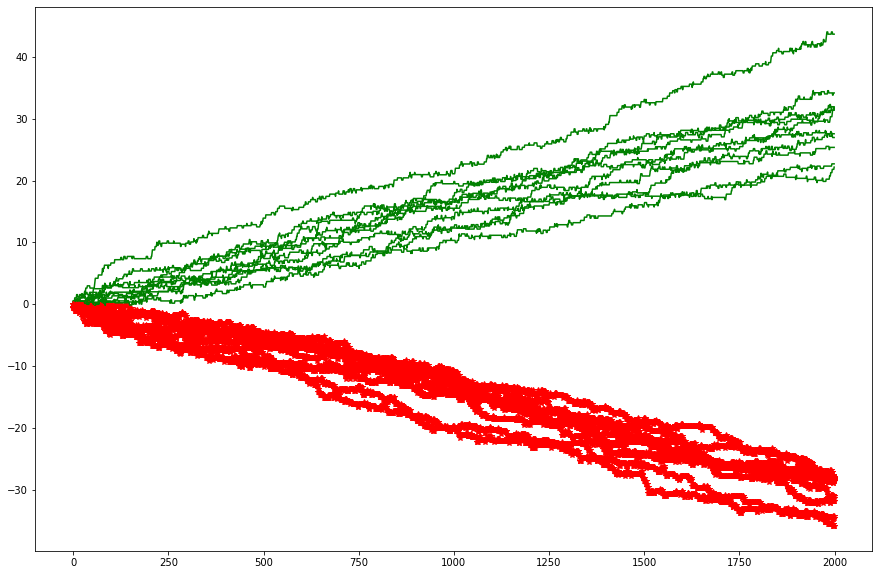

In [5]:
rewards = []
env = Env(data, prob, steps=2000)
mappings = env.mapping
plt.figure(figsize=(15, 10))
for _ in range(10):
    plt.plot(sniper(mappings['121'], mappings['401'], env, env.reset()), 'g-')
    plt.plot(sniper(mappings['401'], mappings['121'], env, env.reset()), 'r*')

In [ ]:
plt.figure(figsize=(15, 10))
env = Env(data, prob, 0, [1000, -500], 3000)
plt.plot(sniper(mappings['122'], mappings['401'], env, env.reset()))
plt.plot(sniper(mappings['401'], mappings['122'], env, env.reset()), 'r-')